# Train a multi-layer perceptron on bachelor Wikipedia episode and Reddit data to predict viewer numbers
pyBach is a collection of functions that allows for scraping of bachelor and bachelorette data from Wikipedia and Reddit

In [1]:
#Using https://www.tensorflow.org/tutorials/keras/basic_regression as template NN-regression analysis
import pyBach #my module
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

<ul>
<li>First scrape last 5 season of The Bachelor and The Bachelorette into a pandas dataframe</li>
    <li>Join all individual dataframes into one large dataframe</li>
    <li>Reset the dataframe index</li>
    <li>Add the episode type data via one hot encoding</li>

In [2]:
dfList = []
bachSeasons = range(19,24)
etteSeasons = range(10,15)

for bachSeason in bachSeasons:
    dfList.append(pyBach.scrapeWikiEpiTable(bachSeason, keepTitle=True))
for etteSeason in etteSeasons:
    dfList.append(pyBach.scrapeWikiEpiTable(etteSeason, show='bachelorette', keepTitle=True))

df = pd.concat(dfList)
df.reset_index(drop=True, inplace=True)
# add one hot encoding to label each episode
df = pyBach.appendEpiTypes(df)

In [3]:
df

,numOverall,numInSeason,year,month,day,posix time,isBachelor,season,viewers(millions),title,premiere,tellAll,finale,afterFinale,normal
0,182.0,1.0,2015,1,5,1420434000,1.0,19,7.76,"""season premiere: limo arrivals""",1.0,0.0,0.0,0.0,0.0
1,183.0,2.0,2015,1,12,1421038800,1.0,19,6.48,"""week 2: tractor race""",0.0,0.0,0.0,0.0,1.0
2,184.0,3.0,2015,1,19,1421643600,1.0,19,7.61,"""week 3: guest host jimmy kimmel""",0.0,0.0,0.0,0.0,1.0
3,185.0,4.0,2015,1,26,1422248400,1.0,19,7.95,"""week 4: camping""",0.0,0.0,0.0,0.0,1.0
4,186.0,5.0,2015,2,2,1422853200,1.0,19,8.45,"""week 5: santa fe""",0.0,0.0,0.0,0.0,1.0
5,187.0,6.0,2015,2,9,1423458000,1.0,19,8.70,"""week 6: deadwood, sd""",0.0,0.0,0.0,0.0,1.0
6,188.0,7.0,2015,2,15,1423976400,1.0,19,6.05,"""week 7: iowa""",0.0,0.0,0.0,0.0,1.0
7,189.0,8.0,2015,2,16,1424062800,1.0,19,8.97,"""week 8: hometown dates""",0.0,0.0,0.0,0.0,1.0
8,190.0,9.0,2015,2,23,1424667600,1.0,19,8.97,"""week 9: bali""",0.0,0.0,0.0,0.0,1.0
9,191.0,10.0,2015,3,2,1425272400,1.0,19,8.15,"""the women tell all""",0.0,1.0,0.0,0.0,0.0


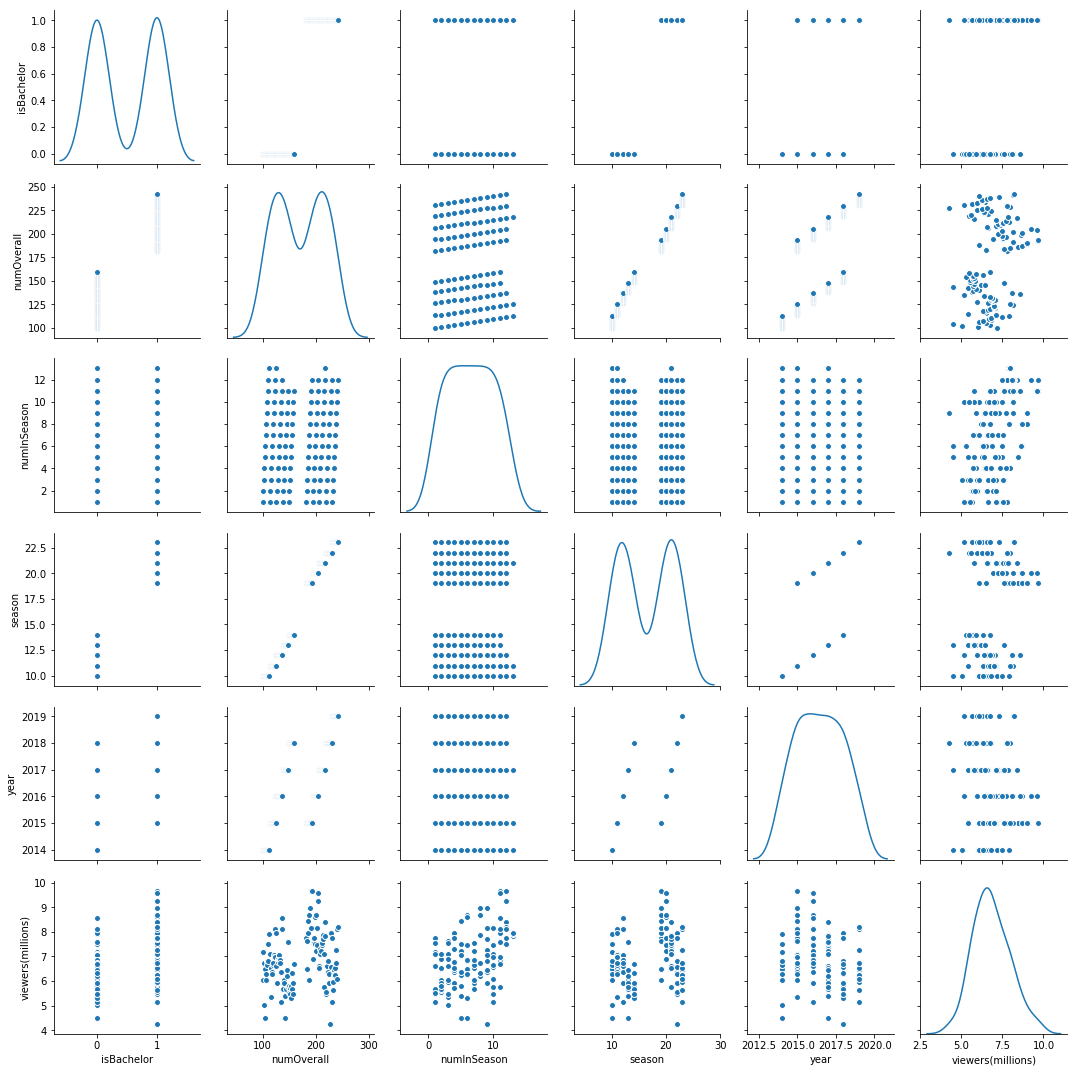

In [4]:
sns.pairplot(df[['isBachelor', 'numOverall', 'numInSeason', 'season', 'year', 'viewers(millions)']], diag_kind="kde")

## Scrape all submission titles and all comments from the week leading up to the episode
This part of the module performs two tasks
<ol>
    <li>Counts the total number of submisisons(AKA posts) and total number of comments in the 'TheBachelor' subreddit the week before the episode airs</li>
        <li>Performs VADER (Valence Aware Dictionary and sEntiment Reasoner) analysis on each submission title and comment text. The individual text gets a single compound score, with -1 being most negative, and 1 being most positive. If no submissions or comments were found for that week the mean sentiment was scored as -2.</li>

In [5]:
#dfAll = pyBach.appendRedditStats(df)
#remove title column
#dfTotal.drop('title', axis=1, inplace=True)

dfTotal = pd.read_pickle('dfAll.pickle')
dfTotal.reset_index(drop=True, inplace=True)

In [6]:
dfTotal.to_csv('dfAll.csv')

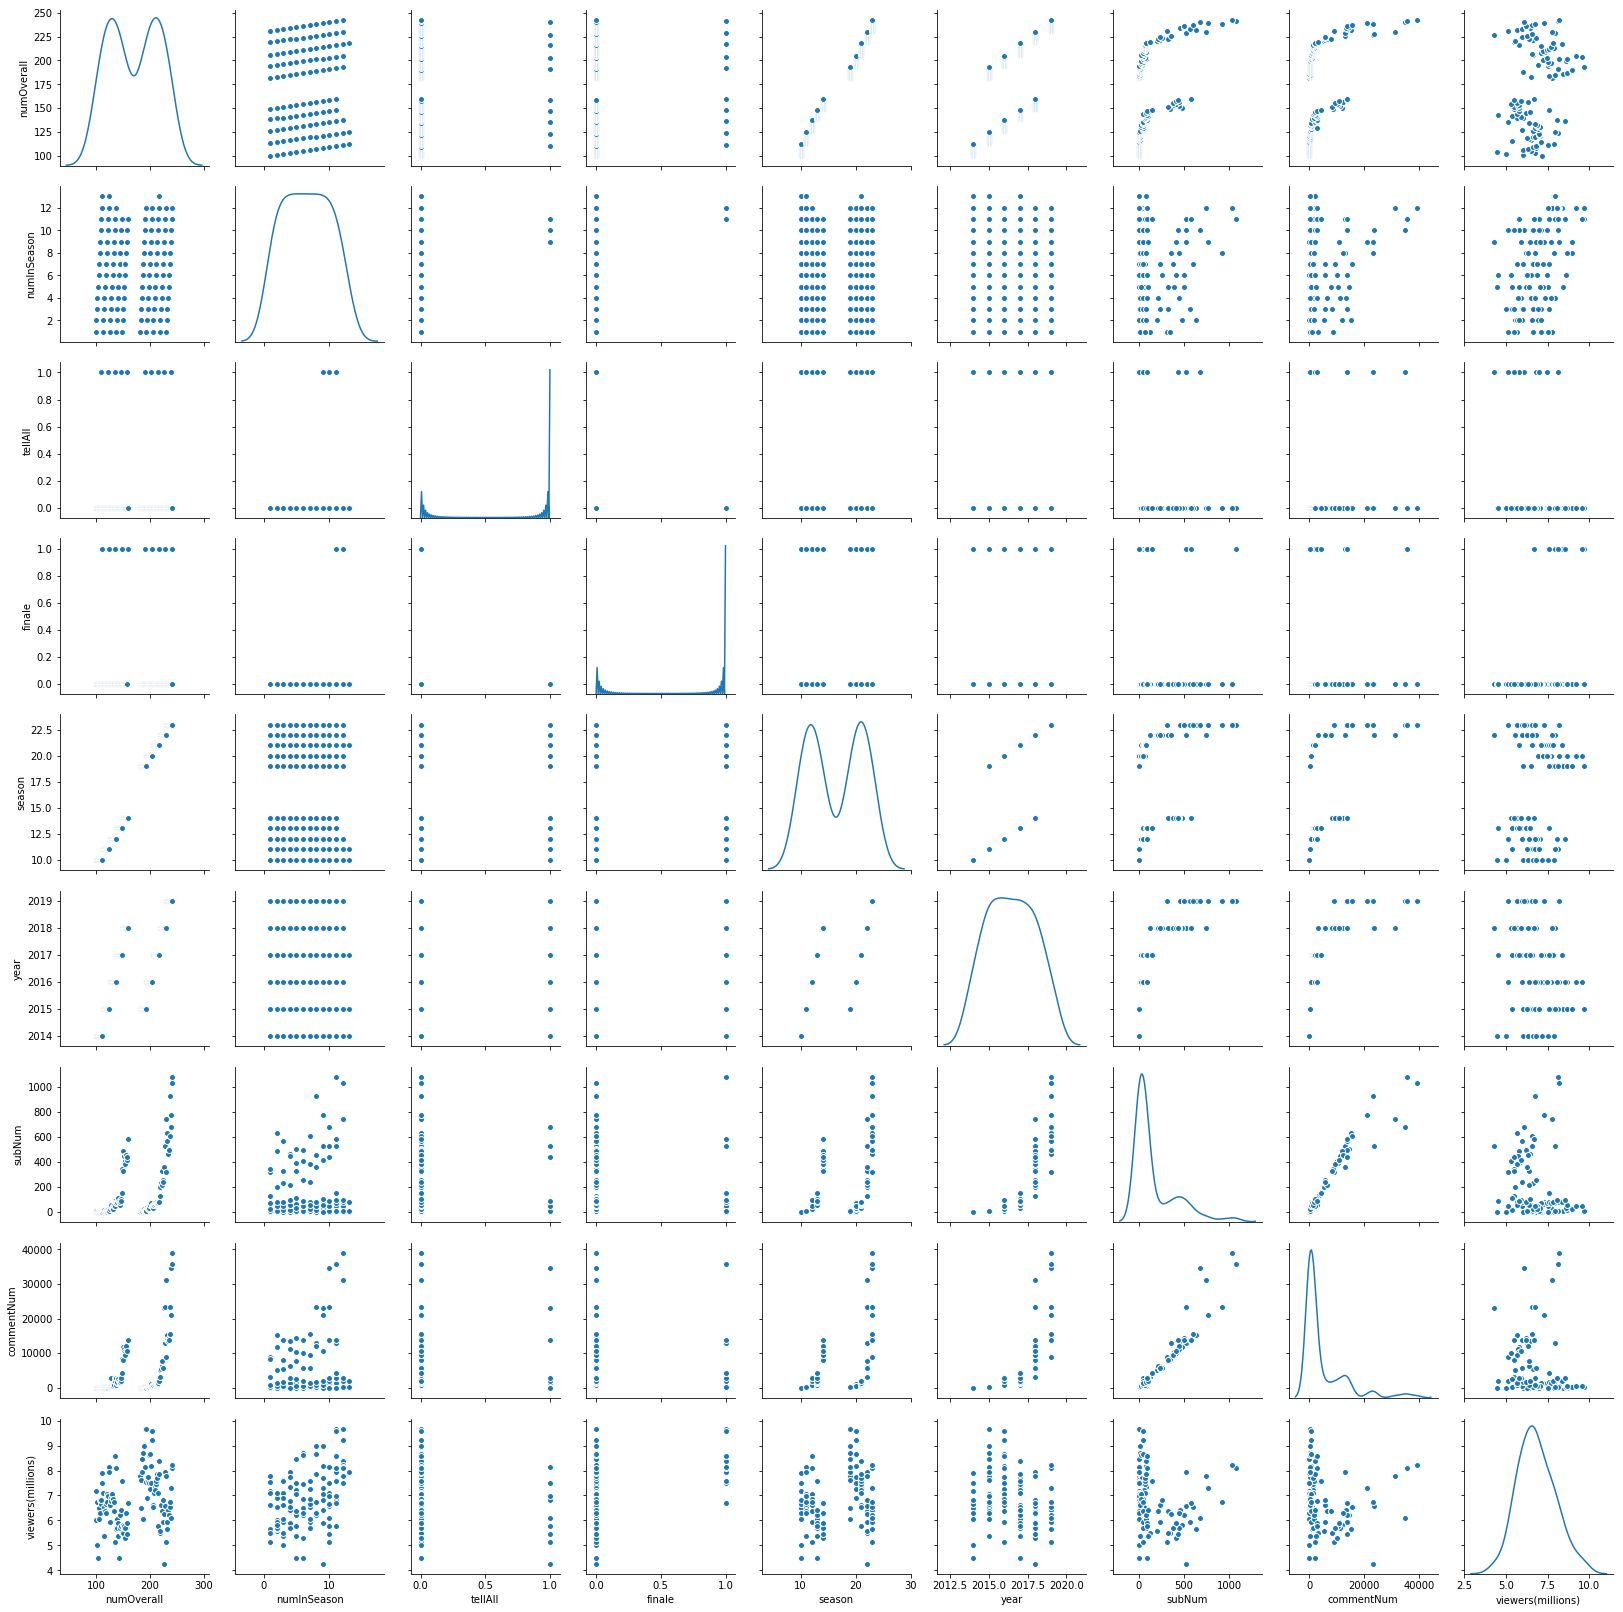

In [7]:
sns.pairplot(dfTotal[['numOverall', 'numInSeason', 'tellAll', 'finale',
                     'season', 'year', 'subNum', 'commentNum', 'viewers(millions)']], diag_kind="kde")

In [8]:
#sns.pairplot(dfTotal[['year', 'subNum', 'commentNum', 
                     #'meanTitleSentiment', 'stdTitleSentiment', 
                     #'meanCommentSentiment', 'stdCommentSentiment','viewers(millions)']], diag_kind="kde")

# Examine performance of multilayer Perceptron using Episode data alone, Episode data with one hot encoding, Reddit counts, and Reddit sentiment analysis
## Create list of lists of features

In [9]:
#establish feature subsets
featureLists = []
featureLists.append(['isBachelor', 
                     'viewers(millions)'])
featureLists.append(['isBachelor', 'numOverall', 'numInSeason', 
                     'season', 'year', 'viewers(millions)'])
featureLists.append(['isBachelor', 'numOverall', 'numInSeason', 
                     'season', 'year', 'normal', 'tellAll', 'finale', 'afterFinale', 'viewers(millions)'])
featureLists.append(['isBachelor', 'numOverall', 'numInSeason',
                     'normal', 'tellAll', 'finale', 'afterFinale',
                     'season', 'year', 'subNum', 'commentNum', 'viewers(millions)'])
featureLists.append(['isBachelor', 'numOverall', 'numInSeason',
                     'normal', 'tellAll', 'finale', 'afterFinale',
                     'season', 'year', 'subNum', 'commentNum', 
                     'meanTitleSentiment', 'stdTitleSentiment', 
                     'meanCommentSentiment', 'stdCommentSentiment','viewers(millions)'])
featureLists.append(dfTotal.columns)

## Split the total date into train, test, and cross-validation sets
60% in train, 20% in test, and 20% in cross-validation sets

In [10]:
dfTrainAll, dfTestAll, dfCVAll = pyBach.splitDfs(dfTotal, rsInt=0)

## Loop through the feature lists to train multiple models

In [11]:
#Instantiate lists to keep trained models and scalers for normalizing data
testLosses = []
cvLosses = []
models = [];
scalers = [];
#Train the models on subsets of features
for features in featureLists:
    dfTrain = dfTrainAll[features]
    dfCV = dfCVAll[features]
    trainLabels = dfTrain['viewers(millions)']
    #There is an early stop parameter in pyBach.trainNN (100 epochs w/o improvement), prevents overfitting
    scaler, model = pyBach.trainNN(dfTrain, epochNum=10000)
    #collect models
    models.append(model)
    #collect scalers, probably not necessary...
    scalers.append(scaler)
    #pop off dfCV labels
    cvLabels = dfCV.pop('viewers(millions)')
    #normalized dfCV using scaler
    trainNorm = scaler.transform(dfTrain)
    cvNorm = scaler.transform(dfCV)
    testLoss, _, _ = model.evaluate(trainNorm, trainLabels, verbose=0)
    cvLoss, _, _ = model.evaluate(cvNorm, cvLabels, verbose=0)
    testLosses.append(testLoss)
    cvLosses.append(cvLoss)

C:\Users\joshl\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................
....................................................................................................
....................................................................................................
..............................................................................................

## Examine the loss (MSE) of each model on the cross-validation and training sets

Text(0.5,1,'Best performing feature set on Validation set is: Episode Data; loss: 0.31')

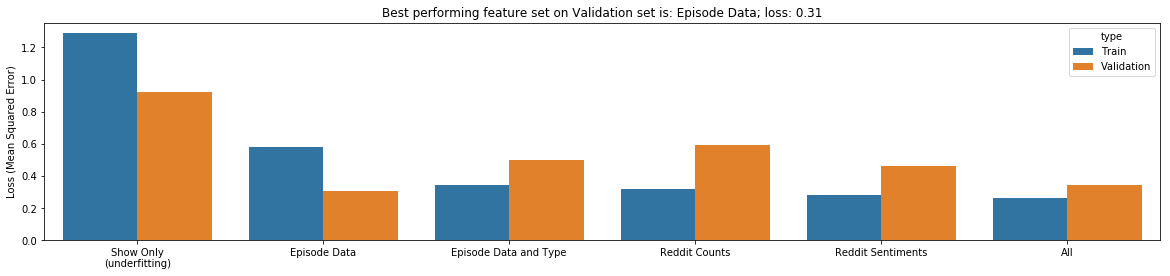

In [12]:
labelList = ['Show Only\n(underfitting)', 'Episode Data', 'Episode Data and Type', 'Reddit Counts', 'Reddit Sentiments', 'All']
zippedList = list(zip(testLosses + cvLosses,
                      ['Train']*len(testLosses) + ['Validation']*len(cvLosses),
                      labelList + labelList))

# Create a dataframe from zipped list
dfObj = pd.DataFrame(zippedList, columns = ['loss' , 'type', 'label'],) 
fig, ax = plt.subplots()
fig.set_figwidth(20)
ax = sns.barplot(x='label', y='loss', hue='type', data=dfObj, ax=ax)
ax.set_ylabel('Loss (Mean Squared Error)')
ax.set_xlabel('')
bestIdx = np.array(cvLosses).argmin()
ax.set_title('Best performing feature set on Validation set is: ' + labelList[bestIdx] + '; loss: '
             + str(format(cvLosses[bestIdx], '.2f')))

## Look at the Loss (MSE) per Epoch in the best model

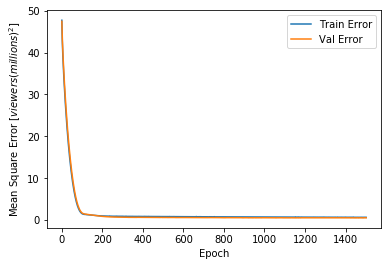

In [13]:
bestModel = models[bestIdx]
bestScaler = scalers[bestIdx]
#lets see the history of the bestModel
history = bestModel.history
# "borrowed" from https://www.tensorflow.org/tutorials/keras/basic_regression
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$viewers(millions)^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.legend()
  plt.show()

plot_history(history)

## Use model with lowest loss (MSE) to predict test set

In [14]:
## Use test data to predict performance on data model has not seen
bestFeatures = featureLists[bestIdx]
dfTest = dfTestAll[bestFeatures]
testLabels = dfTest.pop('viewers(millions)')
testNorm = bestScaler.transform(dfTest)
testPredictions = bestModel.predict(testNorm).flatten()

## Scatterplot of test labels and predictions

Text(0.5,1,'R-Square is: 0.65')

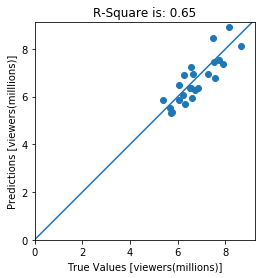

In [15]:
# "borrowed" from https://www.tensorflow.org/tutorials/keras/basic_regression
plt.scatter(testLabels, testPredictions)
plt.xlabel('True Values [viewers(millions)]')
plt.ylabel('Predictions [viewers(milllions)]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
# Give R^2 value in title
SST = sum((testLabels-testLabels.mean())**2)
SSE = sum((testLabels - testPredictions)**2)
Rsq = (SST-SSE)/SST
plt.title('R-Square is: ' + str(format(Rsq, '.2f')))

## Plot Error in Histogram

Mean Absolute Error if mean of test set is predicted : 0.69 million viewers


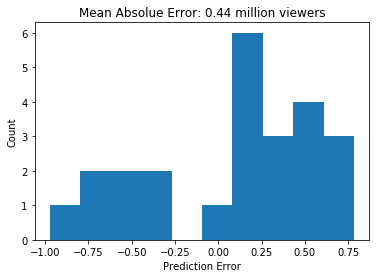

In [16]:
error = testLabels - testPredictions
mae = abs(error).mean()
percError = error/testLabels*100
mape = abs(percError).mean()
n, myBins, patches = plt.hist(error, label='Error')
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")
plt.title('Mean Absolue Error: ' + str(format(mae, '.2f')) + ' million viewers')
testError = testLabels - testLabels.mean()
maeTest = abs(testError).mean()
print('Mean Absolute Error if mean of test set is predicted : ' + str(format(maeTest, '.2f')) + ' million viewers')